This is a short notebook for plotting the eigenstate populations of a 2D 25x25 system, and a 1D 20x20 system, for a fixed offset and electric field, all coupling parameterised to DFT, and three different epsilon values for the coulombic interaction. The parameters are listed in the presentations I made for Jochen at the end of May 2024. Here, because the number of eigenstates is too large to plot them all on one graph, I bin the eigenstates by intervals of kT, and then plot the average eigenstate populations found in each bin. 

This leads to some information loss, as you cannot see which specific eigenstate is hybridised, so I plotted scatter graphs alongside these, which only plot points for the XT-character being greater than 0.05. See the powerpoint for a definition of XT-character. For each point, I plot the corresponding average e-h distance of the participating CT-states, to see which CT-states the excitons are mixed with. For the e-h distance function, I normalise the CT-state populations, because I don't want the exciton populations affecting the calculcation of the average e-h distance, only the CT-state populations relative to each other should affect the average e-h distance of an adiabat.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import XSH_eigenstates_Filip as XSF

import sys
sys.path.insert(0, '/scratch/fivanovic/X-SH/T6-PDI/production_runs/analysis_scripts')
import xsh_analysis_functions as XSA

In [2]:
vecs = XSF.build_lattice(40,1,5)
dons, accs = XSF.DA_index(vecs, 20)
nearest_neighbours = XSF.build_connectivity(vecs, 5)

CT_states = XSF.define_CT_states_twophase(dons, accs)
XT_states = XSF.define_XT_states(accs)

H_CT_e3 = XSF.build_CT_block(CT_states, vecs, nearest_neighbours, -288, 45.82263, -20.6, -1e-3) #500 best interaction constant

H_XT = XSF.build_XT_block(XT_states, nearest_neighbours, 390, 85.45891)
H_XT_CT = XSF.build_XT_CT_block(XT_states, CT_states, nearest_neighbours, 61.8)

H = XSF.build_full_Hamiltonian(H_CT_e3, H_XT, H_XT_CT)

physical_eigenvals, physical_eigenvecs = XSF.get_eigen(H)
binned_eigenvals, binned_eigenvecs, used_energy_bins = XSF.bin_eigenspectrum(physical_eigenvals, physical_eigenvecs, 25)

#binned_eigenvals = binned_eigenvals[16:70]
#binned_eigenvecs = binned_eigenvecs[16:70]
#used_energy_bins = used_energy_bins[16:70]

In [3]:
def adiabat_XT_character(eigenvec_matrix, XT_states):

    hybrid_extents = []
    matrix_transpose = eigenvec_matrix.T

    for eigenvector in matrix_transpose:
        XT_population = XSF.XT_site_populations(eigenvector, XT_states)
        total_hybridisation = sum(XT_population)
        hybrid_extents.append(total_hybridisation)

    return hybrid_extents

In [4]:
def adiabat_CT_character(eigenvec_matrix, CT_states):

    hybrid_extents = []
    number_CT_states = len(CT_states)
    matrix_transpose = eigenvec_matrix.T

    for eigenvector in matrix_transpose:
        total_CT_population = sum([c**2 for c in eigenvector[:number_CT_states]])
        hybrid_extents.append(total_CT_population)
    
    return hybrid_extents

In [5]:
def single_diabat_projection(diabat, eigenvector_matrix):

    matrix_transpose = eigenvector_matrix.T
    diabat_projections = []

    for eigenvector in matrix_transpose:
        diabat_projection = eigenvector[diabat]**2
        diabat_projections.append(diabat_projection)

    return diabat_projections

In [6]:
def get_avg_xdistance(eigenvec_matrix, CT_states, x_distances):
    '''
    Calculates the average distance (in angstroms, along x-axis) between carriers for each eigenvector, and returns this as a
    list of distances, in the same order as the eigenvectors and eigenvalues (in increasing energy)
    '''

    matrix_transpose = eigenvec_matrix.T
    number_CT_states = len(CT_states)

    average_distances = []

    for eigenvec in matrix_transpose:

        CT_eigenvec = eigenvec[:number_CT_states]
        CT_populations = CT_eigenvec**2
        avg_distance = 0

        if np.sum(CT_populations) == 0:
            average_distances.append(avg_distance)
            continue

        renormalisation_factor = 1/np.sum(CT_populations)
        renormalised_CT_pops = CT_populations*renormalisation_factor

        for diabat in range(number_CT_states):
            distance_contribution = renormalised_CT_pops[diabat]*abs(x_distances[diabat])
            avg_distance = avg_distance + distance_contribution
        
        average_distances.append(avg_distance)
    
    return average_distances

Text(0.02, 0.5, 'Binned eigenstate energy /meV')

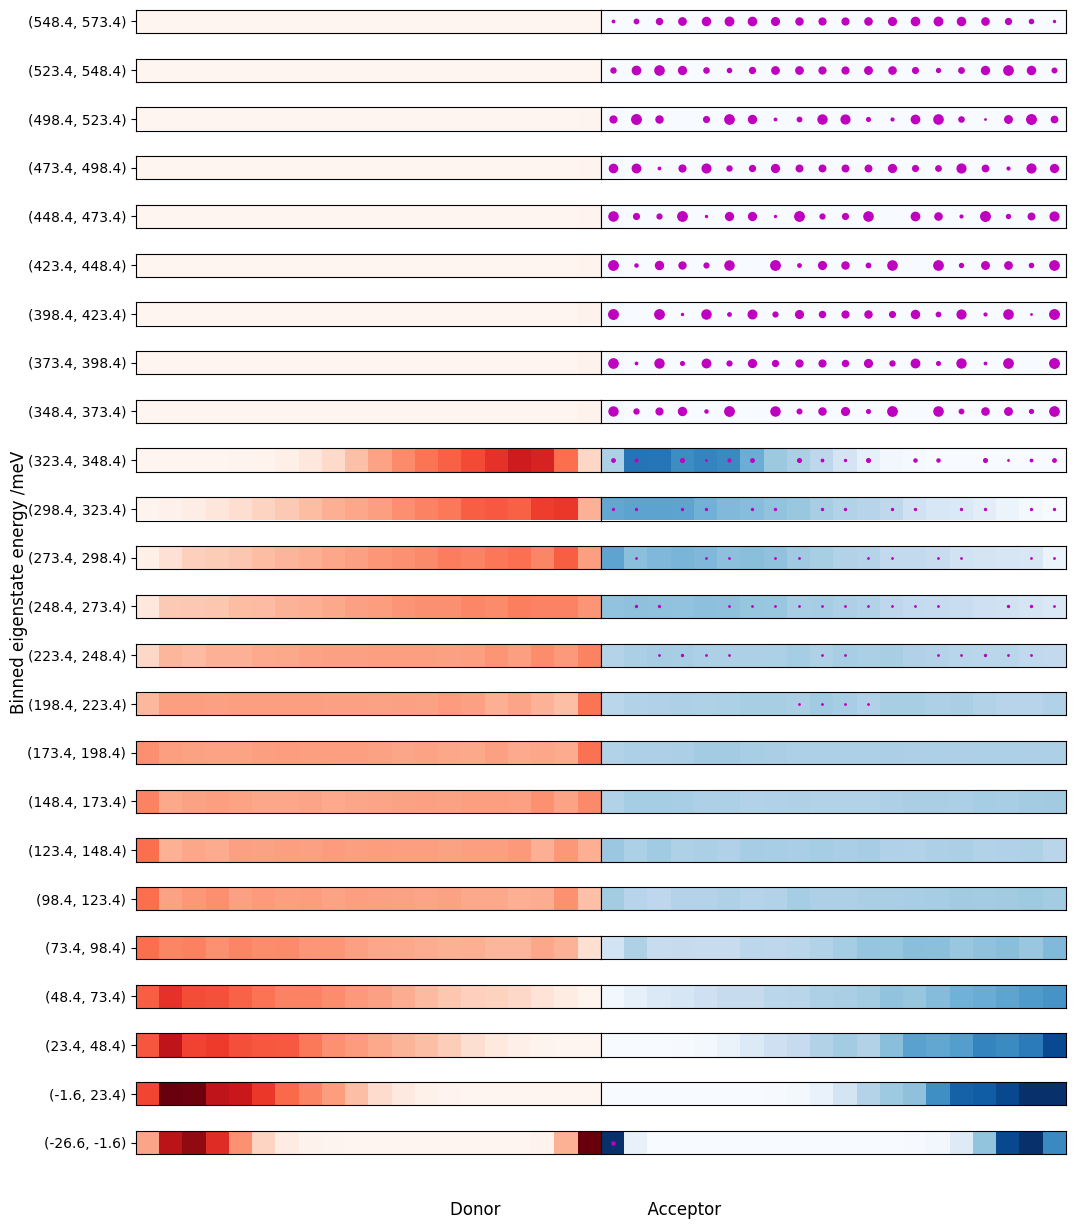

In [8]:
average_dpops, average_apops, average_exc_pops = XSF.average_binned_populations(binned_eigenvecs, dons, accs, XT_states, 1)
fig, axes = XSF.plot_eigenspectrum(average_dpops, average_apops, average_exc_pops, figure_size=(12,13), max_shading=0.15, exciton_radius=500, bins=used_energy_bins)
plt.subplots_adjust(wspace = 0, hspace = 0, bottom=0.05, top=0.95)
fig.supylabel('Binned eigenstate energy /meV')

In [9]:
xt_vals = adiabat_XT_character(physical_eigenvecs, XT_states)
ct_vals = adiabat_CT_character(physical_eigenvecs, CT_states)

exciton_projection = single_diabat_projection(410, physical_eigenvecs)

e3_hybrid_indices = list(filter(lambda x: xt_vals[x] >= 0.05, [j for j in range(len(xt_vals))]))
chosen_hybrid_vals = [xt_vals[index] for index in e3_hybrid_indices]
chosen_eigenvals = [physical_eigenvals[index] for index in e3_hybrid_indices]

x_distances, y_distances = XSF.get_CT_distances(CT_states, vecs)
xdistance_per_eigenvec = get_avg_xdistance(physical_eigenvecs, CT_states, x_distances)
chosen_eigenvec_distances = [xdistance_per_eigenvec[index] for index in e3_hybrid_indices]

xt_distances = [(vecs[k[0]][0] - 95) for k in XT_states]
chosen_eigenvec_xt_distances = [np.array(xt_distances)*physical_eigenvecs[-len(XT_states):, index]**2 for index in e3_hybrid_indices]
chosen_eigenvec_xt_distances = [np.sum(l) for l in chosen_eigenvec_xt_distances]

exciton_coeff_sums = [np.sum(j[400:]) for j in physical_eigenvecs.T]
chosen_coeff_sums = [exciton_coeff_sums[index] for index in e3_hybrid_indices]

Text(0.5, 1.0, 'Adiabat vs Exciton Character - ε = 10 - Offset = 0meV')

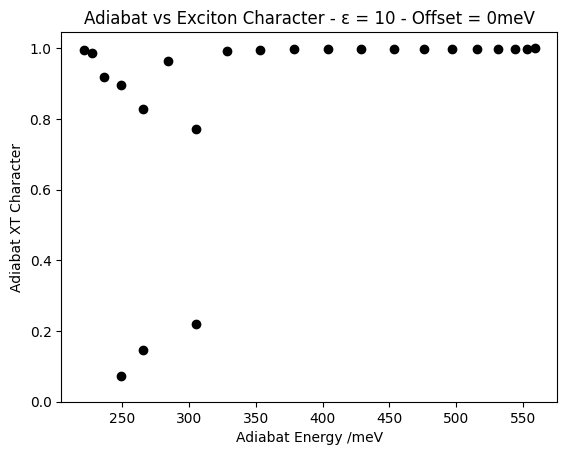

In [10]:
plt.scatter(chosen_eigenvals, chosen_hybrid_vals, color = 'k')
plt.xlabel('Adiabat Energy /meV')
plt.ylabel('Adiabat XT Character')
#plt.xlim([0,1000])
plt.ylim(0)
plt.title('Adiabat vs Exciton Character - \u03B5 = 10 - Offset = 0meV')

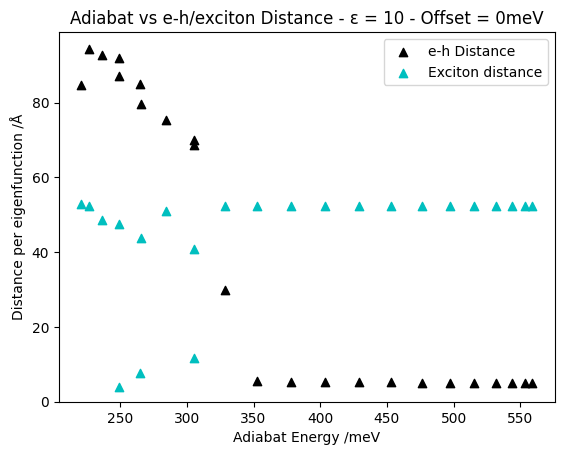

In [11]:
plt.scatter(chosen_eigenvals, chosen_eigenvec_distances, color = 'k', marker = '^', label = 'e-h Distance')
plt.scatter(chosen_eigenvals, chosen_eigenvec_xt_distances, color = 'c', marker = '^', label = 'Exciton distance')
plt.xlabel('Adiabat Energy /meV')
plt.ylabel('Distance per eigenfunction /\u212B')
#plt.xlim([0,500])
plt.ylim(0)
plt.title('Adiabat vs e-h/exciton Distance - \u03B5 = 10 - Offset = 0meV')
plt.legend()

(0.0, 40.0)

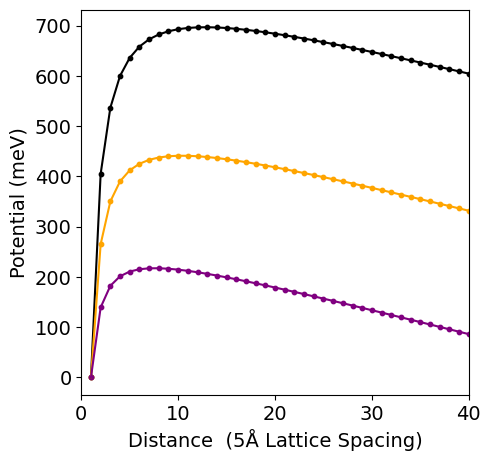

In [12]:
lattice_x_distances = np.arange(1,41)

e3p5_barrier = [((-820/d - 1e-3*1000*5*d) - (-820 - 1e-3*1000*5)) for d in lattice_x_distances]
e6_barrier = [((-540/d - 1e-3*1000*5*d) - (-540 - 1e-3*1000*5)) for d in lattice_x_distances]
e9_barrier = [((-288/d - 1e-3*1000*5*d) - (-288 - 1e-3*1000*5)) for d in lattice_x_distances]
e3p5_barrier_noE = [(-820/d + 820) for d in lattice_x_distances]
e6_barrier_noE = [(-540/d + 540) for d in lattice_x_distances]
e9_barrier_noE = [(-288/d + 288) for d in lattice_x_distances]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (5,5))

ax.plot(lattice_x_distances, e3p5_barrier, color = 'k')
ax.plot(lattice_x_distances, e6_barrier, color = 'orange')
ax.plot(lattice_x_distances, e9_barrier, color = 'purple')
ax.scatter(lattice_x_distances, e3p5_barrier, color = 'k', label = r'High $E_{\mathrm{b}}$ ; $\vec{E}$ = 10$^{5}$ Vcm$^{-1}$', s=10)
ax.scatter(lattice_x_distances, e6_barrier, color = 'orange', label = r'Mid $E_{\mathrm{b}}$ ; $\vec{E}$ = 10$^{5}$ Vcm$^{-1}$', s=10)
ax.scatter(lattice_x_distances, e9_barrier, color = 'purple', label = r'Low $E_{\mathrm{b}}$ ; $\vec{E}$ = 10$^{5}$ Vcm$^{-1}$', s=10)
ax.set_ylabel('Potential (meV)', fontsize = 14)
ax.set_xlabel('Distance  (5\u212B Lattice Spacing)', fontsize = 14)
#plt.legend(fontsize = 12, frameon=False, bbox_to_anchor=(1.1,1.1))
ax.xaxis.set_tick_params(labelsize = 14)
ax.yaxis.set_tick_params(labelsize = 14)
ax.set_xlim([0,40])

In [13]:
projected_exciton_indices = list(filter(lambda x: exciton_projection[x] > 0.001, [j for j in range(len(exciton_projection))]))
dominant_xt_indices = list(filter(lambda x: xt_vals[x] >= 0.5, projected_exciton_indices))
dominant_ct_indices = list(filter(lambda x: ct_vals[x] > 0.5, projected_exciton_indices))

xt_exciton_projections = [exciton_projection[index] for index in dominant_xt_indices]
ct_exciton_projections = [exciton_projection[index] for index in dominant_ct_indices]

assoc_xt_vals = [xt_vals[index] for index in dominant_xt_indices]
assoc_ct_vals = [xt_vals[index] for index in dominant_ct_indices]

xt_xdistances = [xdistance_per_eigenvec[index] for index in dominant_xt_indices]
ct_xdistances = [xdistance_per_eigenvec[index] for index in dominant_ct_indices]

assoc_xt_eigenvals = [physical_eigenvals[index] for index in dominant_xt_indices]
assoc_ct_eigenvals = [physical_eigenvals[index] for index in dominant_ct_indices]

Text(0.5, 0.01, 'Eigenstate energy /meV')

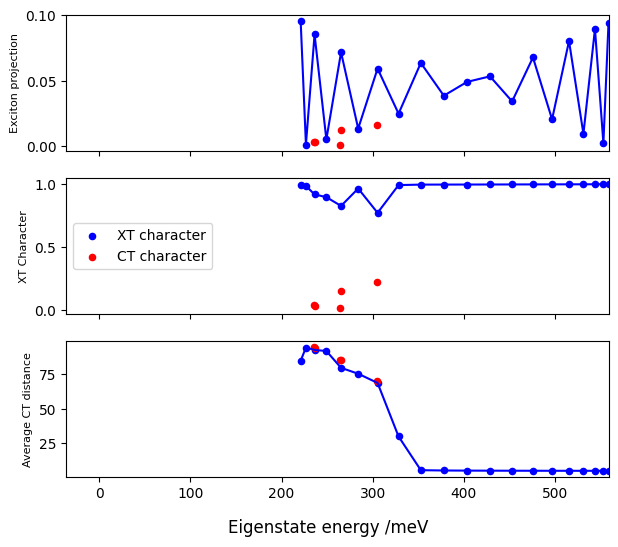

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize = (7,6))

ax[0].scatter(assoc_xt_eigenvals, xt_exciton_projections, color = 'b', s = 20)
ax[0].plot(assoc_xt_eigenvals, xt_exciton_projections, color = 'b')
ax[0].scatter(assoc_ct_eigenvals, ct_exciton_projections, color = 'r', s = 20)
ax[0].set_ylabel('Exciton projection', fontsize=8)

ax[1].scatter(assoc_xt_eigenvals, assoc_xt_vals, color = 'b', s = 20, label = 'XT character')
ax[1].plot(assoc_xt_eigenvals, assoc_xt_vals, color = 'b')
ax[1].scatter(assoc_ct_eigenvals, assoc_ct_vals, color = 'r', label = 'CT character', s = 20)
ax[1].set_ylabel('XT Character', fontsize=8)
ax[1].legend(loc='center left')

ax[2].scatter(assoc_xt_eigenvals, xt_xdistances, color = 'b', s = 20)
ax[2].plot(assoc_xt_eigenvals, xt_xdistances, color = 'b')
ax[2].scatter(assoc_ct_eigenvals, ct_xdistances, color = 'r', s = 20)
ax[2].set_ylabel('Average CT distance', fontsize=8)

plt.xlim(physical_eigenvals[0]-10, physical_eigenvals[-1])
fig.supxlabel('Eigenstate energy /meV')

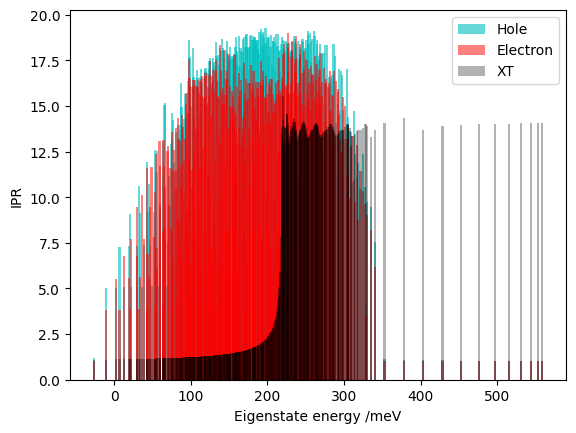

In [15]:
physical_populations = physical_eigenvecs**2
crystal_IPR = np.zeros((4, len(physical_eigenvals)))

for index in range(len(physical_eigenvals)):

    eigenvalue = physical_eigenvals[index]
    eigenvector_populations = physical_populations[:,index]

    exciton_IPR, acceptor_IPR, hole_IPR = XSA.IPR(eigenvector_populations, 420, 20)

    crystal_IPR[0, index] = eigenvalue
    crystal_IPR[1, index] = exciton_IPR
    crystal_IPR[2, index] = acceptor_IPR
    crystal_IPR[3, index] = hole_IPR

plt.bar(crystal_IPR[0], crystal_IPR[3], color = 'c', width = 3, label = 'Hole', alpha = 0.6)
plt.bar(crystal_IPR[0], crystal_IPR[2], color = 'r', width = 3, label = 'Electron', alpha = 0.5)
plt.bar(crystal_IPR[0], crystal_IPR[1], color = 'k', width = 3, label = 'XT', alpha = 0.3)
plt.xlabel('Eigenstate energy /meV')
plt.ylabel('IPR')
plt.legend()

70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0


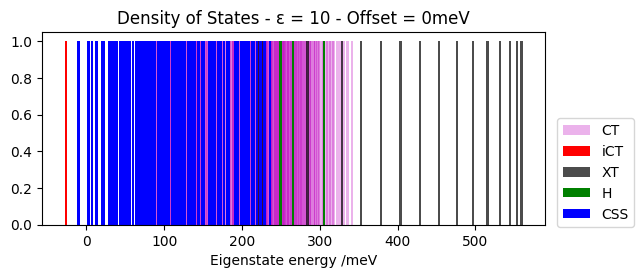

In [16]:
CSS_energies = []
XT_energies = []
INT_energies = []
NON_INT_energies = []
XT_CT_hybrid_energies = []
CT_hybrid_energies = []

for vector_index in range(len(physical_eigenvals)):

    diabatic_populations = physical_populations[:,vector_index]
    diabatic_populations = diabatic_populations[np.newaxis,:]

    CSS, FS, XT, INT = XSA.state_type_populations(diabatic_populations, '/scratch/fivanovic/Work/X-SH/eigenstate_plotting/coulomb_barrier_files/CT_DISTANCES.include', '/scratch/fivanovic/Work/X-SH/eigenstate_plotting/coulomb_barrier_files/e3.5_FRZ_DIAGONALS_COULOMB.include', 3, 3, 420)
    NON_INT = 1 - CSS - XT - INT
    
    if CSS > 0.8:
        CSS_energies.append(physical_eigenvals[vector_index])
    elif XT > 0.95:
        XT_energies.append(physical_eigenvals[vector_index])
    elif INT > 0.8:
        INT_energies.append(physical_eigenvals[vector_index])
    elif (INT + NON_INT + CSS) > 0.95:
        CT_hybrid_energies.append(physical_eigenvals[vector_index])
    else:
        XT_CT_hybrid_energies.append(physical_eigenvals[vector_index])

f = plt.figure()
f.set_figheight(2.5)
f.set_figwidth(6.5)

plt.bar(CT_hybrid_energies, np.ones(len(CT_hybrid_energies)), width = 3, color = 'm', label = 'CT', alpha = 0.3)
plt.bar(INT_energies, np.ones(len(INT_energies)), width = 3, color = 'r', label = 'iCT', alpha = 1)
plt.bar(XT_energies, np.ones(len(XT_energies)), width = 3, color = 'k', label = 'XT', alpha = 0.7)
plt.bar(XT_CT_hybrid_energies, np.ones(len(XT_CT_hybrid_energies)), width = 3, color = 'g', label = 'H', alpha = 1)
plt.bar(CSS_energies, np.ones(len(CSS_energies)), width = 3, color = 'b', label = 'CSS')
plt.xlabel('Eigenstate energy /meV')
plt.title('Density of States - \u03B5 = 10 - Offset = 0meV')
plt.legend(bbox_to_anchor = (1.19, 0.59))

In [17]:
def bin_energies(energies, number_bins):

    energy_difference = np.max(energies) - np.min(energies)
    bins = np.arange(np.min(energies), np.max(energies) + energy_difference/number_bins, energy_difference/number_bins)
    bins[-1] = bins[-1] + 1

    bin_indices = np.digitize(energies, bins)
    bar_chart_data = np.zeros((2,len(bins)-1))

    for j in range(1, len(bins)):

        bin_energy = (bins[j] + bins[j-1])/2
        matching_indices = len(np.where(bin_indices == j)[0])

        bar_chart_data[0,j-1] = bin_energy
        bar_chart_data[1,j-1] = matching_indices

    return bar_chart_data

In [18]:
def plot_DOS(ax_object, path, simulation, keyword_list, colour_list, label_list, shading_list, width_list):

    for index in range(len(keyword_list)):

        if keyword_list[index] == 'iCT':
            info_array = np.loadtxt(path + f'/{simulation}/{simulation}_{keyword_list[index]}_bar_info.txt')
            ax_object.bar(info_array, np.ones(1), color=f'{colour_list[index]}', width=width_list[index], label=f'{label_list[index]}', alpha=shading_list[index])
        else:
            info_array = np.loadtxt(path + f'/{simulation}/{simulation}_{keyword_list[index]}_bar_info.txt')
            ax_object.bar(info_array[0], info_array[1], color=f'{colour_list[index]}', width=width_list[index], label=f'{label_list[index]}', alpha=shading_list[index])

In [19]:
keyword = 'e10'

CT_bars = bin_energies(CT_hybrid_energies, 25)
CSS_bars = bin_energies(CSS_energies, 10)
exciton_bars = bin_energies(XT_energies,9)
hybrid_bars = bin_energies(XT_CT_hybrid_energies,7)

barchart_arrays = [exciton_bars, hybrid_bars, CT_bars, CSS_bars, np.array(INT_energies)]
barchart_keywords = ['exciton', 'hybrid', 'CT', 'CSS', 'iCT']

for info in zip(barchart_arrays, barchart_keywords):

    np.savetxt(f'zeroK_barchart_data/{keyword}/{keyword}_{info[1]}_bar_info.txt', info[0])

/tmp/ipykernel_1617685/2661668598.py:6: UserWarning: loadtxt: input contained no data: "/scratch/fivanovic/Work/X-SH/eigenstate_plotting/zeroK_barchart_data/e5_3xCT/e5_3xCT_iCT_bar_info.txt"
  info_array = np.loadtxt(path + f'/{simulation}/{simulation}_{keyword_list[index]}_bar_info.txt')


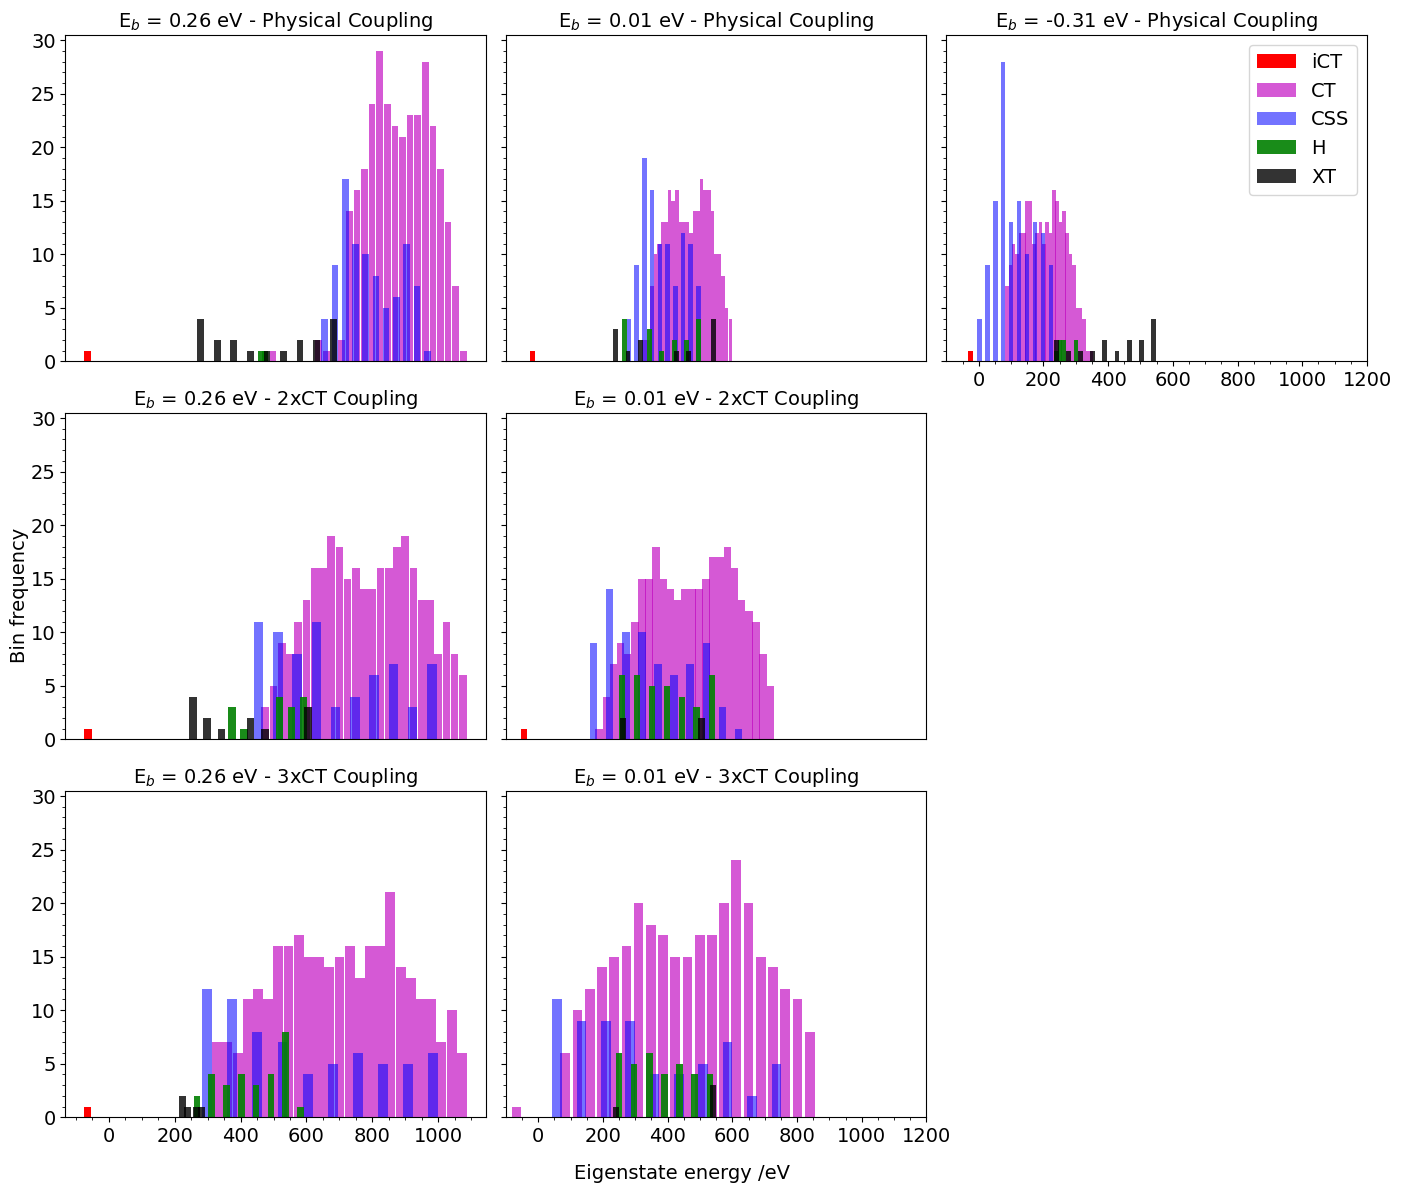

In [20]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(14,12), sharey=True)

colour_list = ['r', 'm', 'b', 'g', 'k']
label_list = ['iCT', 'CT', 'CSS', 'H', 'XT']
barchart_keywords = ['iCT', 'CT', 'CSS', 'hybrid', 'exciton']
shading_list = [1, 0.65, 0.55, 0.90, 0.80]

path = '/scratch/fivanovic/Work/X-SH/eigenstate_plotting/zeroK_barchart_data'

plot_DOS(axs[0,0], path, 'physopt', barchart_keywords, colour_list, label_list, shading_list, width_list=[15, 15, 15, 15, 15])
axs[0,0].set_title('E$_b$ = 0.26 eV - Physical Coupling', fontsize=14)
axs[0,0].set_xticks([])
axs[0,0].yaxis.set_tick_params(labelsize = 14)
axs[0,0].minorticks_on()
plot_DOS(axs[0,1], path, 'e5', barchart_keywords, colour_list, label_list, shading_list, width_list=[15, 11, 14, 15, 15])
axs[0,1].set_title('E$_b$ = 0.01 eV - Physical Coupling', fontsize=14)
axs[0,1].set_xlim([-100,1200])
axs[0,1].set_xticks([])
axs[0,1].minorticks_on()
plot_DOS(axs[0,2], path, 'e10', barchart_keywords, colour_list, label_list, shading_list, width_list=[15, 11, 14, 15, 15])
axs[0,2].set_title('E$_b$ = -0.31 eV - Physical Coupling', fontsize=14)
axs[0,2].legend(fontsize=14)
axs[0,2].set_xlim([-100,1200])
axs[0,2].xaxis.set_tick_params(labelsize = 14)
axs[0,2].minorticks_on()
plot_DOS(axs[1,0], path, 'e3.5_2xCT', barchart_keywords, colour_list, label_list, shading_list, width_list=[20, 20, 25, 20, 20])
axs[1,0].set_title('E$_b$ = 0.26 eV - 2xCT Coupling', fontsize=14)
axs[1,0].set_xticks([])
axs[1,0].yaxis.set_tick_params(labelsize = 14)
axs[1,0].minorticks_on()
plot_DOS(axs[2,0], path, 'e3.5_3xCT', barchart_keywords, colour_list, label_list, shading_list, width_list=[20, 30, 30, 20, 20])
axs[2,0].set_title('E$_b$ = 0.26 eV - 3xCT Coupling', fontsize=14)
axs[2,0].yaxis.set_tick_params(labelsize = 14)
axs[2,0].xaxis.set_tick_params(labelsize = 14)
axs[2,0].minorticks_on()
plot_DOS(axs[1,1], path, 'e5_2xCT', barchart_keywords, colour_list, label_list, shading_list, width_list=[20, 23, 23, 20, 20])
axs[1,1].set_title('E$_b$ = 0.01 eV - 2xCT Coupling', fontsize=14)
axs[1,1].set_xlim([-100,1200])
axs[1,1].set_xticks([])
axs[1,1].minorticks_on()
plot_DOS(axs[2,1], path, 'e5_3xCT', barchart_keywords, colour_list, label_list, shading_list, width_list=[20, 30, 30, 20, 20])
axs[2,1].set_title('E$_b$ = 0.01 eV - 3xCT Coupling', fontsize=14)
axs[2,1].set_xlim([-100,1200])
axs[2,1].xaxis.set_tick_params(labelsize = 14)
axs[2,1].minorticks_on()

axs[1,-1].axis('off')
axs[2,-1].axis('off')

fig.supxlabel('Eigenstate energy /eV', fontsize=14)
fig.supylabel('Bin frequency', fontsize=14)
fig.tight_layout()